In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
import SimpleITK as sitk
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import timm
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
from DataHandler import NoduleDataset

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
    
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

c:\Users\user\Documents\me\Coding\Thesis\.torch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


In [2]:
BATCH_SIZE = 16
NUM_EPOCHS = 25
LEARNING_RATE = 1e-4
IMAGE_SIZE = 224
NUM_WORKERS = 4
WEIGHT_DECAY = 0.01

# Paths - using pre-split data to avoid leakage
split_base_path = "../nodule_dataset21/cxr_images/proccessed_data/split_data"

train_images_path = os.path.join(split_base_path, "train", "images")
val_images_path = os.path.join(split_base_path, "val", "images")
test_images_path = os.path.join(split_base_path, "test", "images")

train_csv_path = os.path.join(split_base_path, "train", "metadata_train.csv")
val_csv_path = os.path.join(split_base_path, "val", "metadata_val.csv")
test_csv_path = os.path.join(split_base_path, "test", "metadata_test.csv")

In [3]:
train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=3),
    transforms.ColorJitter(brightness=0.05, contrast=0.05),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [4]:
# %% Load Pre-Split Data

# Also load original data for before/after comparison 
original_csv_path = "./nodule_dataset21/cxr_images/proccessed_data/metadata.csv"

print("Loading metadata...")
train_df = pd.read_csv(train_csv_path)
val_df = pd.read_csv(val_csv_path)
test_df = pd.read_csv(test_csv_path)

# Try to load original data
try:
    original_df = pd.read_csv(original_csv_path)
    has_original = True
    print(f"Original dataset: {len(original_df)} samples")
except:
    has_original = False
    print("Original metadata not found, skipping before/after comparison")

print(f"Train: {len(train_df)} samples")
print(f"Val: {len(val_df)} samples")
print(f"Test: {len(test_df)} samples")

# Combine all splits for total distribution
combined_df = pd.concat([train_df, val_df, test_df], ignore_index=True)
print(f"Total (combined): {len(combined_df)} samples")

# %% Beautiful color palette
color_negative = '#667eea'  # Soft purple
color_positive = '#f093fb'  # Soft pink
colors = [color_negative, color_positive]

# %% Figure 1: Before vs After Upsampling (if original data exists)
if has_original:
    fig1, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig1.patch.set_facecolor('white')
    
    # Original distribution - Bar
    original_counts = original_df['label'].value_counts().sort_index()
    axes[0, 0].bar(['No Nodule', 'Nodule'], original_counts.values, 
                   color=colors, alpha=0.85, edgecolor='white', linewidth=2)
    axes[0, 0].set_ylabel('Number of Images', fontsize=13, fontweight='bold')
    axes[0, 0].set_title('Original Dataset (Before Split & Upsample)', fontsize=15, fontweight='bold', pad=15)
    axes[0, 0].grid(axis='y', alpha=0.3, linestyle='--')
    axes[0, 0].set_facecolor('#ffffff')
    for i, v in enumerate(original_counts.values):
        axes[0, 0].text(i, v + 50, str(v), ha='center', va='bottom', 
                        fontsize=12, fontweight='bold', color=colors[i])
    
    # Original distribution - Pie
    wedges, texts, autotexts = axes[0, 1].pie(original_counts.values, 
                                               labels=['No Nodule', 'Nodule'], 
                                               autopct='%1.1f%%',
                                               colors=colors, 
                                               startangle=90,
                                               explode=(0.05, 0.05),
                                               shadow=True)
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
        autotext.set_fontsize(11)
    for text in texts:
        text.set_fontsize(12)
        text.set_fontweight('bold')
    axes[0, 1].set_title('Original Distribution (%)', fontsize=15, fontweight='bold', pad=15)
    
    # After split & upsample - Bar
    combined_counts = combined_df['label'].value_counts().sort_index()
    axes[1, 0].bar(['No Nodule', 'Nodule'], combined_counts.values, 
                   color=colors, alpha=0.85, edgecolor='white', linewidth=2)
    axes[1, 0].set_ylabel('Number of Images', fontsize=13, fontweight='bold')
    axes[1, 0].set_title('After Split & Upsample (All Splits Combined)', fontsize=15, fontweight='bold', pad=15)
    axes[1, 0].grid(axis='y', alpha=0.3, linestyle='--')
    axes[1, 0].set_facecolor('#ffffff')
    for i, v in enumerate(combined_counts.values):
        axes[1, 0].text(i, v + 100, str(v), ha='center', va='bottom', 
                        fontsize=12, fontweight='bold', color=colors[i])
    
    # After split & upsample - Pie
    wedges, texts, autotexts = axes[1, 1].pie(combined_counts.values, 
                                               labels=['No Nodule', 'Nodule'], 
                                               autopct='%1.1f%%',
                                               colors=colors, 
                                               startangle=90,
                                               explode=(0.05, 0.05),
                                               shadow=True)
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
        autotext.set_fontsize(11)
    for text in texts:
        text.set_fontsize(12)
        text.set_fontweight('bold')
    axes[1, 1].set_title('After Split & Upsample (%)', fontsize=15, fontweight='bold', pad=15)
    
    plt.tight_layout()
    plt.savefig('before_after_split_upsample.png', dpi=150, bbox_inches='tight', facecolor='white')
    plt.show()
    
    print("\n✓ Before/After comparison saved to 'before_after_split_upsample.png'")

Loading metadata...
Original metadata not found, skipping before/after comparison
Train: 5725 samples
Val: 782 samples
Test: 785 samples
Total (combined): 7292 samples


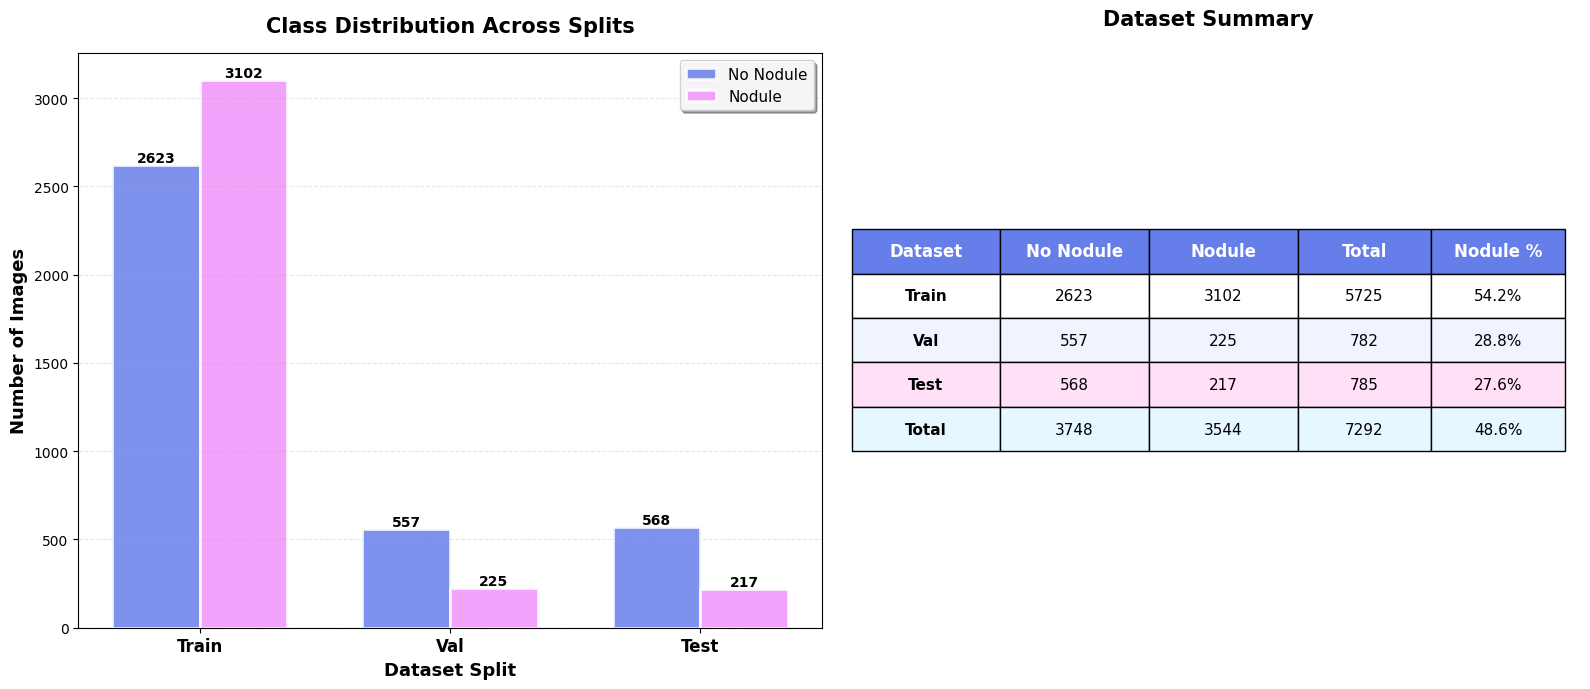

✓ Split distribution saved to 'split_distribution.png'


In [5]:
# %% Figure 2: Train/Val/Test Distribution
fig2, axes = plt.subplots(1, 2, figsize=(16, 7))
fig2.patch.set_facecolor('white')

# Grouped bar chart
splits_data = {
    'Train': train_df['label'].value_counts().sort_index(),
    'Val': val_df['label'].value_counts().sort_index(),
    'Test': test_df['label'].value_counts().sort_index()
}

x = np.arange(len(splits_data))
width = 0.35
bars1 = axes[0].bar(x - width/2, [splits_data[k][0] for k in splits_data.keys()], 
                    width, label='No Nodule', color=color_negative, alpha=0.85, 
                    edgecolor='white', linewidth=2)
bars2 = axes[0].bar(x + width/2, [splits_data[k][1] for k in splits_data.keys()], 
                    width, label='Nodule', color=color_positive, alpha=0.85, 
                    edgecolor='white', linewidth=2)

axes[0].set_xlabel('Dataset Split', fontsize=13, fontweight='bold')
axes[0].set_ylabel('Number of Images', fontsize=13, fontweight='bold')
axes[0].set_title('Class Distribution Across Splits', fontsize=15, fontweight='bold', pad=15)
axes[0].set_xticks(x)
axes[0].set_xticklabels(splits_data.keys(), fontsize=12, fontweight='bold')
axes[0].legend(fontsize=11, framealpha=0.9, shadow=True)
axes[0].grid(axis='y', alpha=0.3, linestyle='--')
axes[0].set_facecolor('#ffffff')

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height)}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Summary table
summary_data = []
for split_name, split_df in [('Train', train_df), ('Val', val_df), ('Test', test_df), ('Total', combined_df)]:
    no_nodule = (split_df['label'] == 0).sum()
    nodule = (split_df['label'] == 1).sum()
    total = len(split_df)
    nodule_pct = f"{nodule/total*100:.1f}%" if total > 0 else "0%"
    summary_data.append([split_name, no_nodule, nodule, total, nodule_pct])

if has_original:
    # Add original row at the top
    orig_no_nodule = (original_df['label'] == 0).sum()
    orig_nodule = (original_df['label'] == 1).sum()
    orig_total = len(original_df)
    orig_pct = f"{orig_nodule/orig_total*100:.1f}%"
    summary_data.insert(0, ['Original', orig_no_nodule, orig_nodule, orig_total, orig_pct])

axes[1].axis('tight')
axes[1].axis('off')
table = axes[1].table(cellText=summary_data,
                      colLabels=['Dataset', 'No Nodule', 'Nodule', 'Total', 'Nodule %'],
                      cellLoc='center',
                      loc='center',
                      colWidths=[0.2, 0.2, 0.2, 0.18, 0.18])
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 2.5)

# Style header with gradient
for i in range(5):
    table[(0, i)].set_facecolor('#667eea')
    table[(0, i)].set_text_props(weight='bold', color='white', size=12)

# Alternate row colors
row_colors = ['#ffffff', '#f0f4ff', '#ffe0f7', '#e6f7ff', '#e8f5e9', '#fff3e0']
for i in range(1, len(summary_data) + 1):
    for j in range(5):
        table[(i, j)].set_facecolor(row_colors[(i-1) % len(row_colors)])
        table[(i, j)].set_text_props(weight='normal' if j > 0 else 'bold')

axes[1].set_title('Dataset Summary', fontsize=15, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig('split_distribution.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print("✓ Split distribution saved to 'split_distribution.png'")

In [6]:
# %% Print detailed statistics
print("\n" + "="*70)
print("📊 DETAILED STATISTICS")
print("="*70)

if has_original:
    print("\nORIGINAL DATASET (Before Split):")
    print(f"   Total images: {len(original_df)}")
    print(f"   No Nodule (0): {original_counts[0]:,} ({original_counts[0]/len(original_df)*100:.1f}%)")
    print(f"   Nodule (1): {original_counts[1]:,} ({original_counts[1]/len(original_df)*100:.1f}%)")
    print(f"   Imbalance ratio: 1:{original_counts[0]/original_counts[1]:.2f}")

print("\nAFTER SPLIT & UPSAMPLE:")
print(f"   Total images (combined): {len(combined_df)}")
combined_counts = combined_df['label'].value_counts().sort_index()
print(f"   No Nodule (0): {combined_counts[0]:,} ({combined_counts[0]/len(combined_df)*100:.1f}%)")
print(f"   Nodule (1): {combined_counts[1]:,} ({combined_counts[1]/len(combined_df)*100:.1f}%)")
print(f"   Imbalance ratio: 1:{combined_counts[0]/combined_counts[1]:.2f}")

print("\nINDIVIDUAL SPLITS:")
train_counts = train_df['label'].value_counts().sort_index()
print(f"\n   Training Set ({len(train_df)} images):")
print(f"      No Nodule: {train_counts[0]:,} ({train_counts[0]/len(train_df)*100:.1f}%)")
print(f"      Nodule: {train_counts[1]:,} ({train_counts[1]/len(train_df)*100:.1f}%)")

val_counts = val_df['label'].value_counts().sort_index()
print(f"\n   Validation Set ({len(val_df)} images):")
print(f"      No Nodule: {val_counts[0]:,} ({val_counts[0]/len(val_df)*100:.1f}%)")
print(f"      Nodule: {val_counts[1]:,} ({val_counts[1]/len(val_df)*100:.1f}%)")

test_counts = test_df['label'].value_counts().sort_index()
print(f"\n   Test Set ({len(test_df)} images):")
print(f"      No Nodule: {test_counts[0]:,} ({test_counts[0]/len(test_df)*100:.1f}%)")
print(f"      Nodule: {test_counts[1]:,} ({test_counts[1]/len(test_df)*100:.1f}%)")

print("\n" + "="*70)
print("✨ All visualizations saved successfully!")
print("="*70)


📊 DETAILED STATISTICS

AFTER SPLIT & UPSAMPLE:
   Total images (combined): 7292
   No Nodule (0): 3,748 (51.4%)
   Nodule (1): 3,544 (48.6%)
   Imbalance ratio: 1:1.06

INDIVIDUAL SPLITS:

   Training Set (5725 images):
      No Nodule: 2,623 (45.8%)
      Nodule: 3,102 (54.2%)

   Validation Set (782 images):
      No Nodule: 557 (71.2%)
      Nodule: 225 (28.8%)

   Test Set (785 images):
      No Nodule: 568 (72.4%)
      Nodule: 217 (27.6%)

✨ All visualizations saved successfully!


In [7]:
# Create datasets - each pointing to its own split directory
train_dataset = NoduleDataset(train_df, train_images_path, transform=train_transform)
val_dataset = NoduleDataset(val_df, val_images_path, transform=val_transform)
test_dataset = NoduleDataset(test_df, test_images_path, transform=val_transform)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, 
                         num_workers=NUM_WORKERS, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, 
                       num_workers=NUM_WORKERS, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, 
                        num_workers=NUM_WORKERS, pin_memory=True)

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import timm

class TransformerBlock(nn.Module):
    """Ultra-lightweight Transformer block with spatial downsampling"""
    def __init__(self, dim, num_heads=2, mlp_ratio=1.0, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = nn.MultiheadAttention(dim, num_heads, dropout=dropout, batch_first=True)
        self.norm2 = nn.LayerNorm(dim)
        
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Linear(dim, mlp_hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_hidden_dim, dim),
            nn.Dropout(dropout)
        )
    
    def forward(self, x):
        B, C, H, W = x.shape
        
        # OPTIMIZATION: Downsample spatial dims for attention if too large
        if H * W > 196:  # If feature map > 14x14
            x_down = F.adaptive_avg_pool2d(x, (14, 14))
            B_d, C_d, H_d, W_d = x_down.shape
            x_seq = x_down.flatten(2).transpose(1, 2)
        else:
            x_seq = x.flatten(2).transpose(1, 2)
            H_d, W_d = H, W
        
        # Multi-head self-attention with residual
        x_norm = self.norm1(x_seq)
        attn_out, _ = self.attn(x_norm, x_norm, x_norm)
        x_seq = x_seq + attn_out
        
        # MLP with residual
        x_seq = x_seq + self.mlp(self.norm2(x_seq))
        
        # Reshape back
        x_out = x_seq.transpose(1, 2).reshape(B, C, H_d, W_d)
        
        # Upsample back if needed
        if H_d != H or W_d != W:
            x_out = F.interpolate(x_out, size=(H, W), mode='bilinear', align_corners=False)
        
        return x + x_out  # Residual from original


class FPN(nn.Module):
    """Feature Pyramid Network for multi-scale feature fusion"""
    def __init__(self, in_channels_list, out_channels=256):
        """
        Args:
            in_channels_list: List of input channels from each stage [C2, C3, C4, C5]
                             For ResNet50: [256, 512, 1024, 2048]
            out_channels: Output channels for all pyramid levels (typically 256)
        """
        super().__init__()
        
        # Lateral connections (1x1 conv to reduce channels)
        self.lateral_convs = nn.ModuleList([
            nn.Conv2d(in_channels, out_channels, kernel_size=1)
            for in_channels in in_channels_list
        ])
        
        # Output convs (3x3 conv to reduce aliasing after upsampling)
        self.output_convs = nn.ModuleList([
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
            for _ in in_channels_list
        ])
    
    def forward(self, features):
        """
        Args:
            features: List of feature maps [C2, C3, C4, C5] from backbone
        Returns:
            List of FPN feature maps [P2, P3, P4, P5]
        """
        # Build laterals
        laterals = [lateral_conv(feat) for lateral_conv, feat in zip(self.lateral_convs, features)]
        
        # Top-down fusion
        for i in range(len(laterals) - 1, 0, -1):
            # Upsample higher-level feature
            upsampled = F.interpolate(laterals[i], size=laterals[i-1].shape[-2:], 
                                     mode='nearest')
            # Add to lower-level feature
            laterals[i-1] = laterals[i-1] + upsampled
        
        # Apply output convolutions
        outputs = [output_conv(lateral) for output_conv, lateral in zip(self.output_convs, laterals)]
        
        return outputs


class ResNetFPNWithTransformers(nn.Module):
    """ResNet-50 + FPN + Multi-Scale Transformer Blocks for Classification"""
    def __init__(self, num_classes=2, pretrained=True, fpn_out_channels=256, 
                 num_heads=2, dropout=0.1):
        super().__init__()
        
        # Load pretrained ResNet-50
        backbone = timm.create_model('resnet50', pretrained=pretrained, num_classes=0)
        
        # Extract ResNet stages
        self.stem = nn.Sequential(
            backbone.conv1,
            backbone.bn1,
            backbone.act1,
            backbone.maxpool
        )
        self.stage1 = backbone.layer1  # 256 channels, H/4 x W/4 (56x56)
        self.stage2 = backbone.layer2  # 512 channels, H/8 x W/8 (28x28)
        self.stage3 = backbone.layer3  # 1024 channels, H/16 x W/16 (14x14)
        self.stage4 = backbone.layer4  # 2048 channels, H/32 x W/32 (7x7)
        
        # Feature Pyramid Network
        self.fpn = FPN(
            in_channels_list=[256, 512, 1024, 2048],
            out_channels=fpn_out_channels
        )
        
        # Transformer blocks on FPN outputs (applied to P4 and P5 for efficiency)
        # P4 and P5 have smaller spatial dimensions, making transformers more efficient
        self.trans_p4 = TransformerBlock(fpn_out_channels, num_heads=num_heads, 
                                         mlp_ratio=1.0, dropout=dropout)
        self.trans_p5 = TransformerBlock(fpn_out_channels, num_heads=num_heads, 
                                         mlp_ratio=1.0, dropout=dropout)
        
        # Global pooling and classifier
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        
        # Aggregate all FPN levels for classification
        self.classifier = nn.Linear(fpn_out_channels * 4, num_classes)
        
    def forward(self, x):
        # Backbone feature extraction
        x = self.stem(x)
        
        c2 = self.stage1(x)   # [B, 256, 56, 56]
        c3 = self.stage2(c2)  # [B, 512, 28, 28]
        c4 = self.stage3(c3)  # [B, 1024, 14, 14]
        c5 = self.stage4(c4)  # [B, 2048, 7, 7]
        
        # FPN fusion
        fpn_features = self.fpn([c2, c3, c4, c5])  # [P2, P3, P4, P5], all 256 channels
        p2, p3, p4, p5 = fpn_features
        
        # Apply transformers to coarser levels (P4 and P5)
        p4_enhanced = self.trans_p4(p4)  # [B, 256, 14, 14]
        p5_enhanced = self.trans_p5(p5)  # [B, 256, 7, 7]
        
        # Global average pooling on all FPN levels
        pooled_p2 = self.global_pool(p2).flatten(1)
        pooled_p3 = self.global_pool(p3).flatten(1)
        pooled_p4 = self.global_pool(p4_enhanced).flatten(1)
        pooled_p5 = self.global_pool(p5_enhanced).flatten(1)
        
        # Concatenate multi-scale features
        x = torch.cat([pooled_p2, pooled_p3, pooled_p4, pooled_p5], dim=1)  # [B, 1024]
        
        # Classification
        x = self.classifier(x)
        
        return x

In [9]:
# Initialize model
print("\nInitializing ResNet-50 + FPN + Multi-Scale Transformers...")
model = ResNetFPNWithTransformers(
    num_classes=2, 
    pretrained=False, 
    fpn_out_channels=256,
    num_heads=2, 
    dropout=0.1
)

# Load your trained ResNet-50 weights into the backbone
print("Loading pretrained ResNet-50 weights from resnet50-baseline-nodule.pth")
checkpoint = torch.load('./resnet50-baseline-nodule.pth')

# Extract backbone weights from checkpoint
pretrained_dict = checkpoint['model_state_dict'] if 'model_state_dict' in checkpoint else checkpoint

# Create a mapping for the backbone weights
model_dict = model.state_dict()
pretrained_dict_filtered = {}

for k, v in pretrained_dict.items():
    # Map old ResNet keys to new model structure
    if k.startswith('conv1'):
        pretrained_dict_filtered['stem.0.' + k] = v
    elif k.startswith('bn1'):
        pretrained_dict_filtered['stem.1.' + k] = v
    elif k.startswith('layer1'):
        pretrained_dict_filtered['stage1.' + k[7:]] = v
    elif k.startswith('layer2'):
        pretrained_dict_filtered['stage2.' + k[7:]] = v
    elif k.startswith('layer3'):
        pretrained_dict_filtered['stage3.' + k[7:]] = v
    elif k.startswith('layer4'):
        pretrained_dict_filtered['stage4.' + k[7:]] = v
    # Note: We don't load the old classifier weights as the architecture changed

# Update model dict with pretrained weights
model_dict.update(pretrained_dict_filtered)
model.load_state_dict(model_dict, strict=False)
print("✓ Loaded pretrained backbone weights")

model = model.to(device)

# FREEZE the ResNet backbone (train FPN + Transformers + Classifier)
for name, param in model.named_parameters():
    if any(x in name for x in ['stem', 'stage1', 'stage2', 'stage3', 'stage4']):
        if not any(x in name for x in ['fpn', 'trans']):
            param.requires_grad = False

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
frozen_params = sum(p.numel() for p in model.parameters() if not p.requires_grad)
total_params = trainable_params + frozen_params

print(f"\nParameter Summary:")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,} ({100*trainable_params/total_params:.2f}%)")
print(f"  Frozen parameters: {frozen_params:,} ({100*frozen_params/total_params:.2f}%)")

# Loss and optimizer (only optimize trainable params)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), 
                       lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)

print("\n✓ Model ready for training!")
print("✓ Frozen: ResNet backbone")
print("✓ Training: FPN + Transformer blocks (P4, P5) + Classifier")


Initializing ResNet-50 + FPN + Multi-Scale Transformers...
Loading pretrained ResNet-50 weights from resnet50-baseline-nodule.pth
✓ Loaded pretrained backbone weights

Parameter Summary:
  Total parameters: 27,646,018
  Trainable parameters: 4,137,986 (14.97%)
  Frozen parameters: 23,508,032 (85.03%)

✓ Model ready for training!
✓ Frozen: ResNet backbone
✓ Training: FPN + Transformer blocks (P4, P5) + Classifier


In [10]:
# %% Training Functions
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    all_probs = []
    
    pbar = tqdm(loader, desc='Training')
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        probs = torch.softmax(outputs, dim=1)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs[:, 1].cpu().detach().numpy())
        
        pbar.set_postfix({'loss': running_loss/len(loader), 'acc': 100.*correct/total})
    
    epoch_loss = running_loss / len(loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc, all_preds, all_labels, all_probs

def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for images, labels in tqdm(loader, desc='Validation'):
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            probs = torch.softmax(outputs, dim=1)
            _, predicted = outputs.max(1)
            
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())  # probability of positive class

    epoch_loss = running_loss / len(loader)
    epoch_acc = 100. * correct / total
    
    # Binary metrics
    binary_precision = precision_score(all_labels, all_preds, average='binary', zero_division=0)
    binary_recall = recall_score(all_labels, all_preds, average='binary', zero_division=0)
    binary_f1 = f1_score(all_labels, all_preds, average='binary', zero_division=0)
    binary_auc = roc_auc_score(all_labels, all_probs)
    
    return epoch_loss, epoch_acc, all_preds, all_labels, all_probs, binary_precision, binary_recall, binary_f1, binary_auc

In [11]:
# Check for overlap
train_files = set(train_df['img_name'])
val_files = set(val_df['img_name'])
test_files = set(test_df['img_name'])

print(f"Train ∩ Val: {len(train_files & val_files)}")
print(f"Train ∩ Test: {len(train_files & test_files)}")
print(f"Val ∩ Test: {len(val_files & test_files)}")
# Should all be 0

Train ∩ Val: 0
Train ∩ Test: 0
Val ∩ Test: 0


In [12]:
# %% Training Loop
print("\nStarting training...")
history = {
    'train_loss': [], 'train_acc': [], 'train_auc': [], 'train_precision': [],
    'val_loss': [], 'val_acc': [], 'val_auc': [], 'val_precision': []
}

best_val_acc = 0.0
best_model_path = 'best_resvit_fpn_multiscale.pth'

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    print("-" * 50)
    
    # Train
    train_loss, train_acc, train_preds, train_labels, train_probs = train_epoch(
        model, train_loader, criterion, optimizer, device)
    
    # Calculate train metrics
    from sklearn.metrics import precision_score
    train_auc = roc_auc_score(train_labels, train_probs)
    train_precision = precision_score(train_labels, train_preds, average='binary', zero_division=0)
    
    # Validate - updated to unpack all 9 return values
    val_loss, val_acc, val_preds, val_labels, val_probs, val_precision, val_recall, val_f1, val_auc = validate(
        model, val_loader, criterion, device)
    
    # Step scheduler
    scheduler.step()
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['train_auc'].append(train_auc)
    history['train_precision'].append(train_precision)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_auc'].append(val_auc)
    history['val_precision'].append(val_precision)
    
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Train AUC: {train_auc:.4f}, Train Precision: {train_precision:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%, Val AUC: {val_auc:.4f}, Val Precision: {val_precision:.4f}")
    print(f"LR: {optimizer.param_groups[0]['lr']:.6f}")
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'val_auc': val_auc,
            'val_precision': val_precision,
            'val_recall': val_recall,
            'val_f1': val_f1,
        }, best_model_path)
        print(f"✓ Saved best model (Val Acc: {val_acc:.2f}%, Val AUC: {val_auc:.4f})")

print("\nTraining completed!")


Starting training...

Epoch 1/25
--------------------------------------------------


Validation: 100%|██████████| 49/49 [00:18<00:00,  2.61it/s]


Train Loss: 0.4949, Train Acc: 76.52%, Train AUC: 0.8432, Train Precision: 0.7771
Val Loss: 0.6522, Val Acc: 68.29%, Val AUC: 0.9155, Val Precision: 0.4755
LR: 0.000100
✓ Saved best model (Val Acc: 68.29%, Val AUC: 0.9155)

Epoch 2/25
--------------------------------------------------


Validation: 100%|██████████| 49/49 [00:16<00:00,  3.03it/s]


Train Loss: 0.4221, Train Acc: 80.47%, Train AUC: 0.8869, Train Precision: 0.8133
Val Loss: 0.3078, Val Acc: 86.83%, Val AUC: 0.9308, Val Precision: 0.8081
LR: 0.000098
✓ Saved best model (Val Acc: 86.83%, Val AUC: 0.9308)

Epoch 3/25
--------------------------------------------------


Validation: 100%|██████████| 49/49 [00:15<00:00,  3.07it/s]


Train Loss: 0.3872, Train Acc: 82.79%, Train AUC: 0.9057, Train Precision: 0.8344
Val Loss: 0.3059, Val Acc: 88.62%, Val AUC: 0.9323, Val Precision: 0.8333
LR: 0.000096
✓ Saved best model (Val Acc: 88.62%, Val AUC: 0.9323)

Epoch 4/25
--------------------------------------------------


Validation: 100%|██████████| 49/49 [00:13<00:00,  3.64it/s]


Train Loss: 0.3398, Train Acc: 84.94%, Train AUC: 0.9280, Train Precision: 0.8520
Val Loss: 0.3068, Val Acc: 87.47%, Val AUC: 0.9398, Val Precision: 0.7309
LR: 0.000094

Epoch 5/25
--------------------------------------------------


Validation: 100%|██████████| 49/49 [00:13<00:00,  3.64it/s]


Train Loss: 0.3202, Train Acc: 85.97%, Train AUC: 0.9368, Train Precision: 0.8657
Val Loss: 0.3470, Val Acc: 83.25%, Val AUC: 0.9316, Val Precision: 0.8507
LR: 0.000090

Epoch 6/25
--------------------------------------------------


Validation: 100%|██████████| 49/49 [00:13<00:00,  3.62it/s]


Train Loss: 0.3017, Train Acc: 86.86%, Train AUC: 0.9436, Train Precision: 0.8714
Val Loss: 0.5181, Val Acc: 76.85%, Val AUC: 0.9429, Val Precision: 0.5561
LR: 0.000086

Epoch 7/25
--------------------------------------------------


Validation: 100%|██████████| 49/49 [00:13<00:00,  3.65it/s]


Train Loss: 0.2821, Train Acc: 88.24%, Train AUC: 0.9508, Train Precision: 0.8854
Val Loss: 0.2695, Val Acc: 88.36%, Val AUC: 0.9442, Val Precision: 0.8131
LR: 0.000082

Epoch 8/25
--------------------------------------------------


Validation: 100%|██████████| 49/49 [00:23<00:00,  2.05it/s]


Train Loss: 0.2690, Train Acc: 88.70%, Train AUC: 0.9550, Train Precision: 0.8906
Val Loss: 0.2965, Val Acc: 86.96%, Val AUC: 0.9487, Val Precision: 0.7143
LR: 0.000077

Epoch 9/25
--------------------------------------------------


Validation: 100%|██████████| 49/49 [00:16<00:00,  3.00it/s]


Train Loss: 0.2488, Train Acc: 89.68%, Train AUC: 0.9620, Train Precision: 0.8974
Val Loss: 0.2563, Val Acc: 89.39%, Val AUC: 0.9532, Val Precision: 0.8060
LR: 0.000071
✓ Saved best model (Val Acc: 89.39%, Val AUC: 0.9532)

Epoch 10/25
--------------------------------------------------


Validation: 100%|██████████| 49/49 [00:13<00:00,  3.54it/s]


Train Loss: 0.2331, Train Acc: 90.20%, Train AUC: 0.9665, Train Precision: 0.9045
Val Loss: 0.2502, Val Acc: 89.26%, Val AUC: 0.9545, Val Precision: 0.7925
LR: 0.000065

Epoch 11/25
--------------------------------------------------


Validation: 100%|██████████| 49/49 [00:13<00:00,  3.60it/s]


Train Loss: 0.2258, Train Acc: 90.72%, Train AUC: 0.9685, Train Precision: 0.9116
Val Loss: 0.2365, Val Acc: 91.18%, Val AUC: 0.9578, Val Precision: 0.8333
LR: 0.000059
✓ Saved best model (Val Acc: 91.18%, Val AUC: 0.9578)

Epoch 12/25
--------------------------------------------------


Validation: 100%|██████████| 49/49 [00:13<00:00,  3.63it/s]


Train Loss: 0.2195, Train Acc: 90.93%, Train AUC: 0.9702, Train Precision: 0.9135
Val Loss: 0.2739, Val Acc: 89.13%, Val AUC: 0.9435, Val Precision: 0.7966
LR: 0.000053

Epoch 13/25
--------------------------------------------------


Validation: 100%|██████████| 49/49 [00:15<00:00,  3.07it/s]


Train Loss: 0.2154, Train Acc: 91.32%, Train AUC: 0.9712, Train Precision: 0.9136
Val Loss: 0.2621, Val Acc: 89.39%, Val AUC: 0.9490, Val Precision: 0.8447
LR: 0.000047

Epoch 14/25
--------------------------------------------------


Validation: 100%|██████████| 49/49 [00:15<00:00,  3.11it/s]


Train Loss: 0.1917, Train Acc: 91.97%, Train AUC: 0.9773, Train Precision: 0.9202
Val Loss: 0.3227, Val Acc: 87.34%, Val AUC: 0.9443, Val Precision: 0.7266
LR: 0.000041

Epoch 15/25
--------------------------------------------------


Validation: 100%|██████████| 49/49 [00:15<00:00,  3.13it/s]


Train Loss: 0.1885, Train Acc: 92.30%, Train AUC: 0.9780, Train Precision: 0.9220
Val Loss: 0.2545, Val Acc: 90.15%, Val AUC: 0.9535, Val Precision: 0.8491
LR: 0.000035

Epoch 16/25
--------------------------------------------------


Validation: 100%|██████████| 49/49 [00:15<00:00,  3.12it/s]


Train Loss: 0.1699, Train Acc: 93.36%, Train AUC: 0.9819, Train Precision: 0.9368
Val Loss: 0.2583, Val Acc: 89.77%, Val AUC: 0.9532, Val Precision: 0.8033
LR: 0.000029

Epoch 17/25
--------------------------------------------------


Validation: 100%|██████████| 49/49 [00:16<00:00,  3.04it/s]


Train Loss: 0.1641, Train Acc: 93.48%, Train AUC: 0.9835, Train Precision: 0.9339
Val Loss: 0.2687, Val Acc: 90.03%, Val AUC: 0.9549, Val Precision: 0.8848
LR: 0.000023

Epoch 18/25
--------------------------------------------------


Validation: 100%|██████████| 49/49 [00:15<00:00,  3.12it/s]


Train Loss: 0.1613, Train Acc: 93.33%, Train AUC: 0.9840, Train Precision: 0.9356
Val Loss: 0.2837, Val Acc: 89.51%, Val AUC: 0.9514, Val Precision: 0.8865
LR: 0.000018

Epoch 19/25
--------------------------------------------------


Validation: 100%|██████████| 49/49 [00:15<00:00,  3.07it/s]


Train Loss: 0.1601, Train Acc: 93.76%, Train AUC: 0.9842, Train Precision: 0.9370
Val Loss: 0.2494, Val Acc: 89.77%, Val AUC: 0.9545, Val Precision: 0.8139
LR: 0.000014

Epoch 20/25
--------------------------------------------------


Validation: 100%|██████████| 49/49 [00:15<00:00,  3.10it/s]


Train Loss: 0.1467, Train Acc: 94.32%, Train AUC: 0.9867, Train Precision: 0.9438
Val Loss: 0.2824, Val Acc: 88.62%, Val AUC: 0.9519, Val Precision: 0.7677
LR: 0.000010

Epoch 21/25
--------------------------------------------------


Validation: 100%|██████████| 49/49 [00:24<00:00,  2.02it/s]


Train Loss: 0.1377, Train Acc: 94.60%, Train AUC: 0.9883, Train Precision: 0.9469
Val Loss: 0.3119, Val Acc: 87.85%, Val AUC: 0.9504, Val Precision: 0.7390
LR: 0.000006

Epoch 22/25
--------------------------------------------------


Validation: 100%|██████████| 49/49 [00:19<00:00,  2.48it/s]


Train Loss: 0.1352, Train Acc: 95.00%, Train AUC: 0.9885, Train Precision: 0.9507
Val Loss: 0.2708, Val Acc: 89.00%, Val AUC: 0.9523, Val Precision: 0.8035
LR: 0.000004

Epoch 23/25
--------------------------------------------------


Validation: 100%|██████████| 49/49 [00:20<00:00,  2.45it/s]


Train Loss: 0.1325, Train Acc: 94.78%, Train AUC: 0.9893, Train Precision: 0.9468
Val Loss: 0.2551, Val Acc: 90.66%, Val AUC: 0.9556, Val Precision: 0.8363
LR: 0.000002

Epoch 24/25
--------------------------------------------------


Validation: 100%|██████████| 49/49 [00:20<00:00,  2.42it/s]


Train Loss: 0.1249, Train Acc: 95.23%, Train AUC: 0.9903, Train Precision: 0.9524
Val Loss: 0.2697, Val Acc: 90.03%, Val AUC: 0.9519, Val Precision: 0.8210
LR: 0.000000

Epoch 25/25
--------------------------------------------------


Validation: 100%|██████████| 49/49 [00:19<00:00,  2.45it/s]

Train Loss: 0.1314, Train Acc: 94.88%, Train AUC: 0.9895, Train Precision: 0.9500
Val Loss: 0.2658, Val Acc: 89.90%, Val AUC: 0.9527, Val Precision: 0.8202
LR: 0.000000

Training completed!


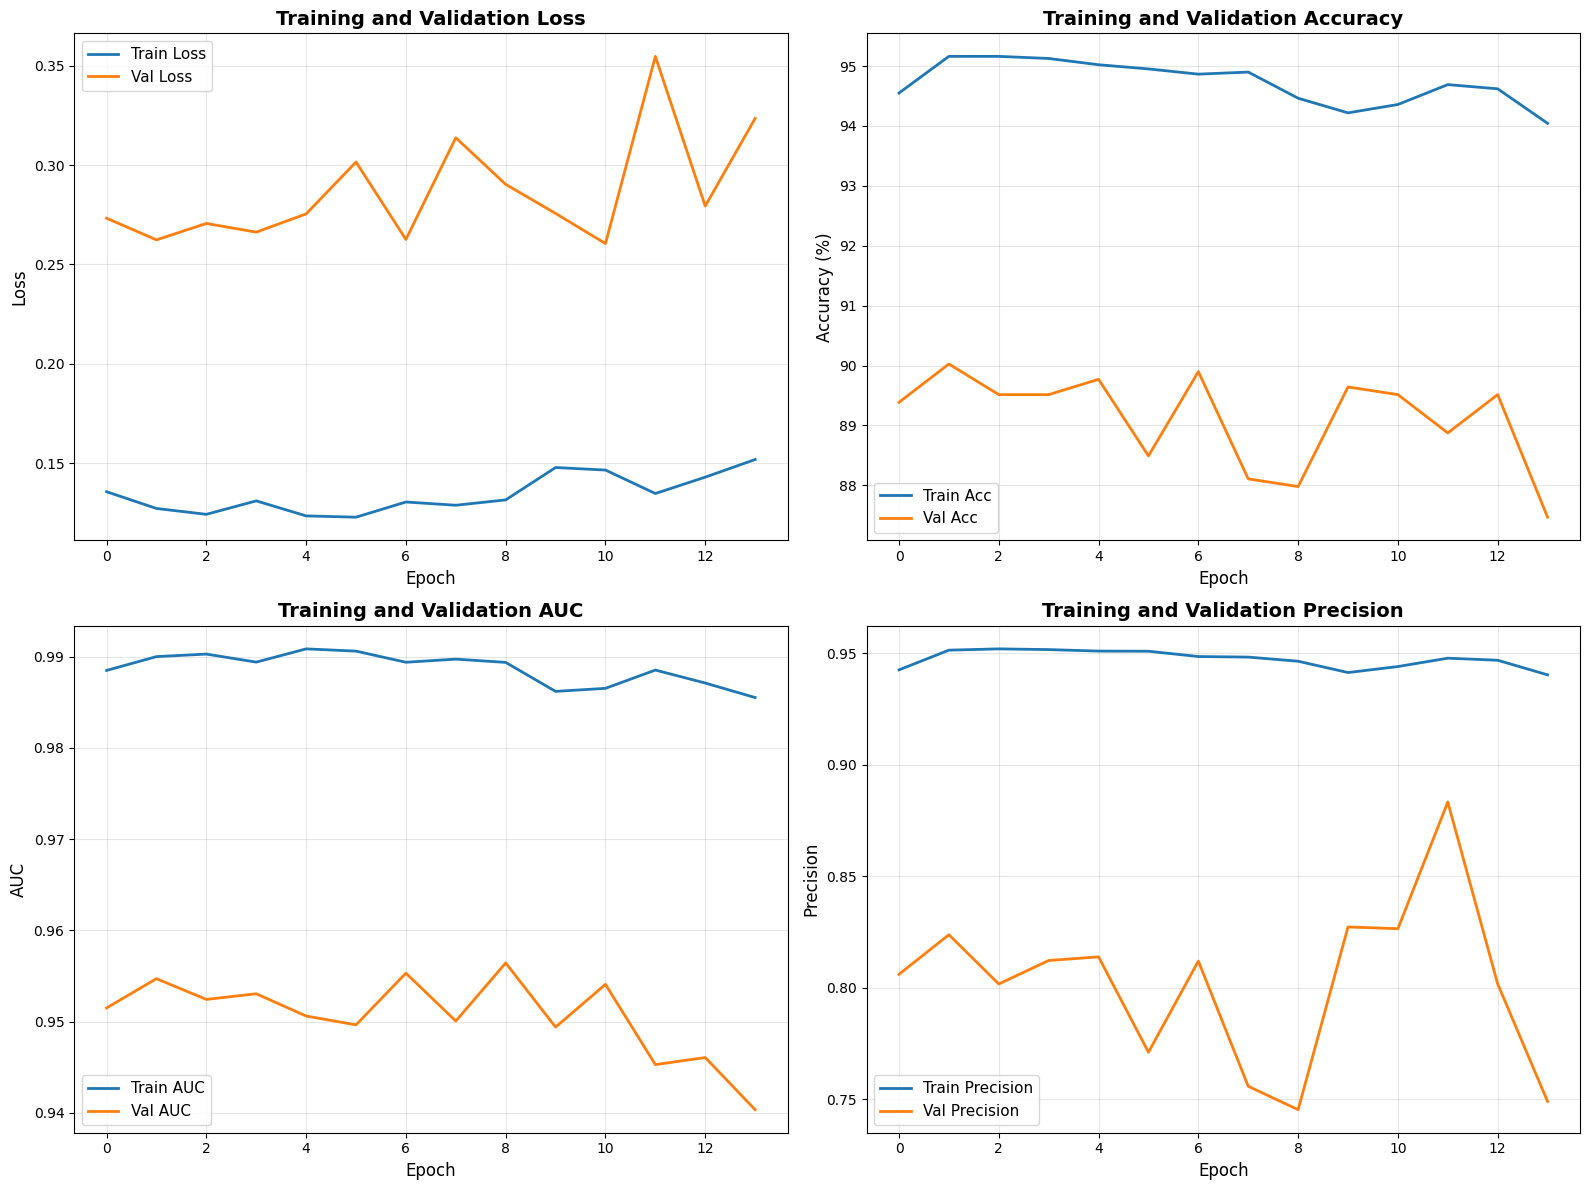

In [14]:
# %% Plot Training History
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Loss plot
ax1.plot(history['train_loss'], label='Train Loss', linewidth=2)
ax1.plot(history['val_loss'], label='Val Loss', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Accuracy plot
ax2.plot(history['train_acc'], label='Train Acc', linewidth=2)
ax2.plot(history['val_acc'], label='Val Acc', linewidth=2)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy (%)', fontsize=12)
ax2.set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

# AUC plot
ax3.plot(history['train_auc'], label='Train AUC', linewidth=2)
ax3.plot(history['val_auc'], label='Val AUC', linewidth=2)
ax3.set_xlabel('Epoch', fontsize=12)
ax3.set_ylabel('AUC', fontsize=12)
ax3.set_title('Training and Validation AUC', fontsize=14, fontweight='bold')
ax3.legend(fontsize=11)
ax3.grid(True, alpha=0.3)

# Precision plot
ax4.plot(history['train_precision'], label='Train Precision', linewidth=2)
ax4.plot(history['val_precision'], label='Val Precision', linewidth=2)
ax4.set_xlabel('Epoch', fontsize=12)
ax4.set_ylabel('Precision', fontsize=12)
ax4.set_title('Training and Validation Precision', fontsize=14, fontweight='bold')
ax4.legend(fontsize=11)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=150)
plt.show()

In [1]:
# %% Load Best Model and Evaluate on Test Set
print("\nLoading best model for testing...")
checkpoint = torch.load("./best_resvit_fpn_multiscale.pth")
model.load_state_dict(checkpoint['model_state_dict'])
    # Validate - updated to unpack all 9 return values
    
test_loss, test_acc, test_preds, test_labels, test_probs, test_precision, test_recall, test_f1, test_auc = validate(model, test_loader, criterion, device)

print(f"\nTest Results:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.2f}%")

# Classification Report
print("\nClassification Report:")
print(classification_report(test_labels, test_preds, target_names=['No Nodule', 'Nodule']))

# ROC AUC Score
auc = roc_auc_score(test_labels, test_probs)
print(f"\nROC AUC Score: {auc:.4f}")


Loading best model for testing...


NameError: name 'torch' is not defined

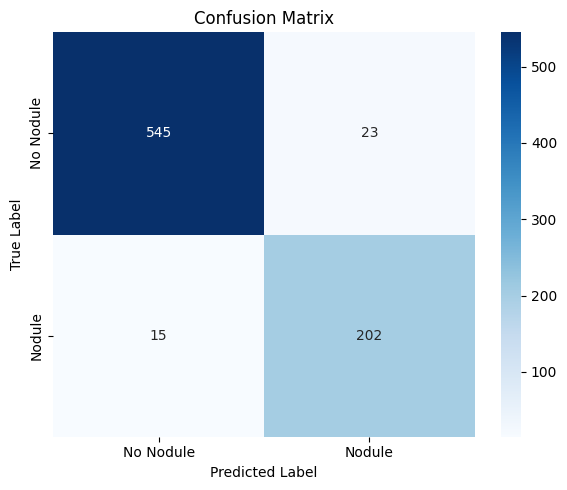

✓ Saved: confusion_matrix.png


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(test_labels, test_preds)
cm_labels = ['No Nodule', 'Nodule']

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=cm_labels, yticklabels=cm_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()
print("✓ Saved: confusion_matrix.png")


In [ ]:
# %% Load Best Model and Evaluate on Test Set
print("\nLoading best model for testing...")
best_model_path = 'best_resvit_multiscale.pth'
model = ResNetWithMultiScaleAttention(num_classes=2, pretrained=False, num_heads=2, dropout=0.1)
model = model.to(device)
checkpoint = torch.load(best_model_path)
model.load_state_dict(checkpoint['model_state_dict'])

test_loss, test_acc, test_preds, test_labels, test_probs, test_prec, test_rec, test_f1, test_auc = validate(model, test_loader, criterion, device)

print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.2f}%")
print(f"Test Precision: {test_prec:.4f}")
print(f"Test Recall: {test_rec:.4f}")
print(f"Test F1-score: {test_f1:.4f}")
print(f"Test ROC AUC: {test_auc:.4f}")

print(f"\n" + "="*70)
print("TEST SET RESULTS")
print("="*70)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.2f}%")

# Classification Report
print("\nClassification Report:")
print(classification_report(test_labels, test_preds, target_names=['No Nodule', 'Nodule']))


Loading best model for testing...


Validation: 100%|██████████| 50/50 [00:12<00:00,  3.98it/s]


Test Loss: 0.1355
Test Accuracy: 95.16%
Test Precision: 0.8978
Test Recall: 0.9309
Test F1-score: 0.9140
Test ROC AUC: 0.9872

TEST SET RESULTS
Test Loss: 0.1355
Test Accuracy: 95.16%

Classification Report:
              precision    recall  f1-score   support

   No Nodule       0.97      0.96      0.97       568
      Nodule       0.90      0.93      0.91       217

    accuracy                           0.95       785
   macro avg       0.94      0.95      0.94       785
weighted avg       0.95      0.95      0.95       785


Confusion Matrix:
[[545  23]
 [ 15 202]]



Testing on subset data...
Subset dataset: 171 samples

Class distribution:
  Nodule (1): 171

Evaluating model on subset...


Validation: 100%|██████████| 11/11 [00:05<00:00,  1.93it/s]


SUBSET TEST RESULTS (NODULE-ONLY DATASET)
Subset Loss: 0.1651
Subset Accuracy: 92.98%
Subset Precision: 1.0000
Subset Recall (True Positive Rate): 0.9298
Subset F1-score: 0.9636
Subset ROC AUC: nan

False Positive Rate: 7.02%
   (Nodules incorrectly classified as No Nodule: 12/171)

Classification Report:
              precision    recall  f1-score   support

   No Nodule       1.00      0.93      0.96       171

   micro avg       1.00      0.93      0.96       171
   macro avg       1.00      0.93      0.96       171
weighted avg       1.00      0.93      0.96       171




c:\Users\Edrill-LT\Documents\Projects\Python\Thoracic-Disease-Classifier-ResNet50\.torch\lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\Edrill-LT\Documents\Projects\Python\Thoracic-Disease-Classifier-ResNet50\.torch\lib\site-packages\sklearn\metrics\_classification.py:2964: UserWarning: labels size, 1, does not match size of target_names, 2
  warnings.warn(


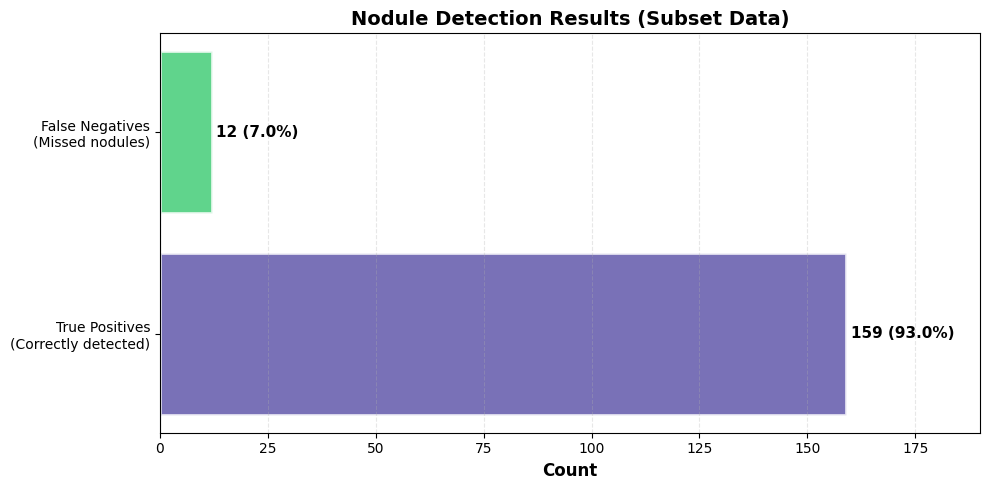

✓ Saved: confusion_matrix_subset.png

COMPARISON: TEST SET vs SUBSET (NODULE-ONLY)
Metric                    Test Set        Subset          Difference     
---------------------------------------------------------------------------
Accuracy (%)              95.16           92.98           -2.18          
F1-Score                  0.9140          0.9636          +0.0496        
ROC AUC                   0.9872          nan             +nan           
False Positive Rate (%)   N/A             7.02            N/A            

💡 Note: False Positive Rate = % of nodules misclassified as 'No Nodule'
   Higher FPR = Model is missing more nodules in this subset


In [ ]:
# %% Test on Subset Data
import os
import pandas as pd
from torch.utils.data import DataLoader
import numpy as np

print("\nTesting on subset data...")

# Load subset metadata
subset_csv_path = "./dataset_nodule21/cxr_images/proccessed_data/subset_metadata2.csv"
subset_images_path = "./dataset_nodule21/cxr_images/proccessed_data/images"

subset_df = pd.read_csv(subset_csv_path)
print(f"Subset dataset: {len(subset_df)} samples")
print(f"\nClass distribution:")
print(f"  Nodule (1): {(subset_df['label'] == 1).sum()}")

# Create subset dataset (no bbox needed for this model)
subset_dataset = NoduleDataset(subset_df, subset_images_path, transform=val_transform, return_bbox=False)
subset_loader = DataLoader(subset_dataset, batch_size=BATCH_SIZE, shuffle=False, 
                           num_workers=NUM_WORKERS, pin_memory=True)

# Evaluate on subset
print("\nEvaluating model on subset...")
subset_loss, subset_acc, subset_preds, subset_labels, subset_probs, subset_prec, subset_rec, subset_f1, subset_auc = validate(
    model, subset_loader, criterion, device)

# Convert to numpy arrays if they aren't already
subset_preds = np.array(subset_preds)
subset_labels = np.array(subset_labels)

# Calculate False Positive Rate (FPR)
# For nodule detection: FP = predicted 0 when actual is 1
false_positives = np.sum((subset_preds == 0) & (subset_labels == 1))
total_positives = np.sum(subset_labels == 1)
false_positive_rate = (false_positives / total_positives * 100) if total_positives > 0 else 0

# Print results
print("\n" + "="*70)
print("SUBSET TEST RESULTS (NODULE-ONLY DATASET)")
print("="*70)
print(f"Subset Loss: {subset_loss:.4f}")
print(f"Subset Accuracy: {subset_acc:.2f}%")
print(f"Subset Precision: {subset_prec:.4f}")
print(f"Subset Recall (True Positive Rate): {subset_rec:.4f}")
print(f"Subset F1-score: {subset_f1:.4f}")
print(f"Subset ROC AUC: {subset_auc:.4f}")
print(f"\nFalse Positive Rate: {false_positive_rate:.2f}%")
print(f"   (Nodules incorrectly classified as No Nodule: {false_positives}/{total_positives})")

# Classification Report (only show Nodule class)
print("\nClassification Report:")
from sklearn.metrics import classification_report
print(classification_report(subset_labels, subset_preds, target_names=['No Nodule', 'Nodule'], labels=[1]))

# Visualization - Detection breakdown only
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

# Detection breakdown
labels_bar = ['True Positives\n(Correctly detected)', 'False Negatives\n(Missed nodules)']
true_positives = np.sum((subset_preds == 1) & (subset_labels == 1))
values = [true_positives, false_positives]
colors_bar = ["#574ea5", "#38ca70"]

bars = ax.barh(labels_bar, values, color=colors_bar, alpha=0.8, edgecolor='white', linewidth=2)
ax.set_xlabel('Count', fontsize=12, fontweight='bold')
ax.set_title('Nodule Detection Results (Subset Data)', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3, linestyle='--')

ax.set_xlim(0, 190)

# Add value labels on bars
for bar, val in zip(bars, values):
    ax.text(val + 1, bar.get_y() + bar.get_height()/2, 
             f'{int(val)} ({val/total_positives*100:.1f}%)',
             va='center', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.savefig('confusion_matrix_subset.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()
print("✓ Saved: confusion_matrix_subset.png")

# Compare with main test set
print("\n" + "="*70)
print("COMPARISON: TEST SET vs SUBSET (NODULE-ONLY)")
print("="*70)
print(f"{'Metric':<25} {'Test Set':<15} {'Subset':<15} {'Difference':<15}")
print("-" * 75)
print(f"{'Accuracy (%)':<25} {test_acc:<15.2f} {subset_acc:<15.2f} {subset_acc - test_acc:<+15.2f}")
print(f"{'F1-Score':<25} {test_f1:<15.4f} {subset_f1:<15.4f} {subset_f1 - test_f1:<+15.4f}")
print(f"{'ROC AUC':<25} {test_auc:<15.4f} {subset_auc:<15.4f} {subset_auc - test_auc:<+15.4f}")
print(f"{'False Positive Rate (%)':<25} {'N/A':<15} {false_positive_rate:<15.2f} {'N/A':<15}")
print("="*75)

print(f"\n💡 Note: False Positive Rate = % of nodules misclassified as 'No Nodule'")
print(f"   Higher FPR = Model is missing more nodules in this subset")